In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck, compute_statistics
from project.evaluation import isa_rpn_metric, Tracker

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
t = Tracker()

In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

t.date = rn
t.logfile = f'{dte}.log'

dte

'Nov_16_2024_101308'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t.device = device
device

'cuda'

### Config for fitter


In [5]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        # pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 5,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    # 'loss': nn.L1Loss(),
    'lr': 0.0001
}

t.model = 'RPN'
t.model_hyperparams = config['model'].config
t.uses_resnet = config['model'].config['resnet']
t.optimizer = f"{config['optimizer']}"
t.epochs = config['epochs']
t.loss = f"{config['loss']}"
t.lr = config['lr']

324


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Load Pretrained Embedder


#### Load RPN Weights


### Load dataset


In [6]:
ds = Dataset()

data = pd.read_csv('targets_kess.csv')
data.shape

(7986, 9)

In [7]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
t.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### `DataLoader` Generator


In [8]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [9]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 tracker=t
                ):
    if cohort == 1:
        t.cohort1 = True
    if cohort == 2:
        t.cohort2 = True
    if cohort == 3:
        t.cohort3 = True
    t.batch_size = batch_size
    t.test_size = test_size
    t.target_shape = target_shape
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader, train_set, val_set

### Fitter


In [10]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

In [11]:
fitter = RPNFitter(config, logger=logger)

### Train-Test Split


In [12]:
_, _, t1, v1 = make_loaders(
    data=data,
    cohort=1,
    batch_size=20
)

_, _, t3, v3 = make_loaders(
    data=data,
    cohort=3,
    batch_size=20
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 664.0)



In [13]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([t1, t3])
test_set = ConcatDataset([v1, v3])

In [14]:
len(train_set)

73

In [15]:
len(test_set)

19

### Training


In [16]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [18]:
fitter = RPNFitter(config, logger=logger)
fold_metrics = []

for i, (train_index, val_index) in enumerate(kf.split(train_set)):
    print(f'Fold {i + 1}/{5}')
    
    train_subset = Subset(train_set, train_index)
    val_subset = Subset(train_set, val_index)
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    thist, vhist, tmhist, vmhist = fitter.fit(train_subset_dl, val_subset_dl)
    
    fold_metrics.append({
        'fold': i + 1,
        'training_history': thist,
        'validation_history': vhist,
        'training_metrics': tmhist,
        'validation_metrics': vmhist
    })

    

INFO:andy:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Fold 1/5


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Fold 2/5


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Fold 3/5


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1

Fold 4/5


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Fold 5/5


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

In [19]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

In [20]:
import numpy as np 
[np.array(fold).mean() for fold in fold_metrics[i]['training_history']]

[0.008848422, 0.008811396, 0.009305584, 0.008843935, 0.009738888]

In [49]:
fold_metrics[0]

thist_array = []
vhist_array = []
v_iou_array = []
v_precision_array = []
v_recall_array = []
v_f1score_array = []


def get_avg_score(set, metric):
    return np.array(fold_metrics[i][set][0][metric]).mean()

for i in range(5):
    print(f'K-Fold {i}')
    
    thist = [np.array(fold).mean() for fold in fold_metrics[i]['training_history']]
    print(f'Training History: {thist}')
    thist_array.append(thist)
    
    vhist = [np.array(fold).mean() for fold in fold_metrics[i]['validation_history']]
    print(f'Validation History: {vhist}')
    vhist_array.append(vhist)
    
    print('\nTraining Metrics')
    print(f"Average IOU: {get_avg_score('training_metrics', 'iou_score')}")
    print(f"Average Precision: {get_avg_score('training_metrics', 'precision_score')}")
    print(f"Average Recall: {get_avg_score('training_metrics', 'recall_score')}")
    print(f"Average F1 Score: {get_avg_score('training_metrics', 'f1_score')}")
    
    print('\nValidation Metrics')
    v_iou = get_avg_score('validation_metrics', 'iou_score')
    print(f"Average IOU: {v_iou}")
    v_iou_array.append(v_iou)
    
    v_precision = get_avg_score('validation_metrics', 'precision_score')
    print(f"Average Precision: {v_precision}")
    v_precision_array.append(v_precision)
    
    v_recall = get_avg_score('validation_metrics', 'recall_score')
    print(f"Average Recall: {v_recall}")
    v_recall_array.append(v_recall)
    
    v_f1 = get_avg_score('validation_metrics', 'f1_score')
    print(f"Average F1 Score: {v_f1}")
    v_f1score_array.append(v_f1)
    
    print('\n===================================\n')

K-Fold 0
Training History: [0.029502576, 0.014747783, 0.018059114, 0.017741922, 0.014632189]
Validation History: [0.01195772, 0.017627725, 0.018204855, 0.01641551, 0.013394471]

Training Metrics
Average IOU: 0.07216234748243708
Average Precision: 0.17635995156035342
Average Recall: 0.12448129063303551
Average F1 Score: 0.11081509777055733

Validation Metrics
Average IOU: 0.3258458259205023
Average Precision: 0.4266936515768369
Average Recall: 0.6620836491386096
Average F1 Score: 0.4609177947044373


K-Fold 1
Training History: [0.011422154, 0.01203766, 0.010530735, 0.009987711, 0.009828198]
Validation History: [0.012309945, 0.010347305, 0.009151395, 0.009240904, 0.009002154]

Training Metrics
Average IOU: 0.32651595418052426
Average Precision: 0.4405109216940814
Average Recall: 0.5990816936667623
Average F1 Score: 0.46492958158768455

Validation Metrics
Average IOU: 0.30683924704790116
Average Precision: 0.37176666359106697
Average Recall: 0.6567030588785807
Average F1 Score: 0.45347190

In [53]:
print(f'Validation - Average IOU: {np.array(v_iou_array).mean()} ')
print(f'Validation - Average Precision: {np.array(v_precision_array).mean()} ')
print(f'Validation - Average Recall: {np.array(v_recall_array).mean()} ')
print(f'Validation - Average F1 Score: {np.array(v_f1score_array).mean()} ')

Validation - Average IOU: 0.3320181167649016 
Validation - Average Precision: 0.45655351508940967 
Validation - Average Recall: 0.5767713952135474 
Validation - Average F1 Score: 0.46877488463052686 


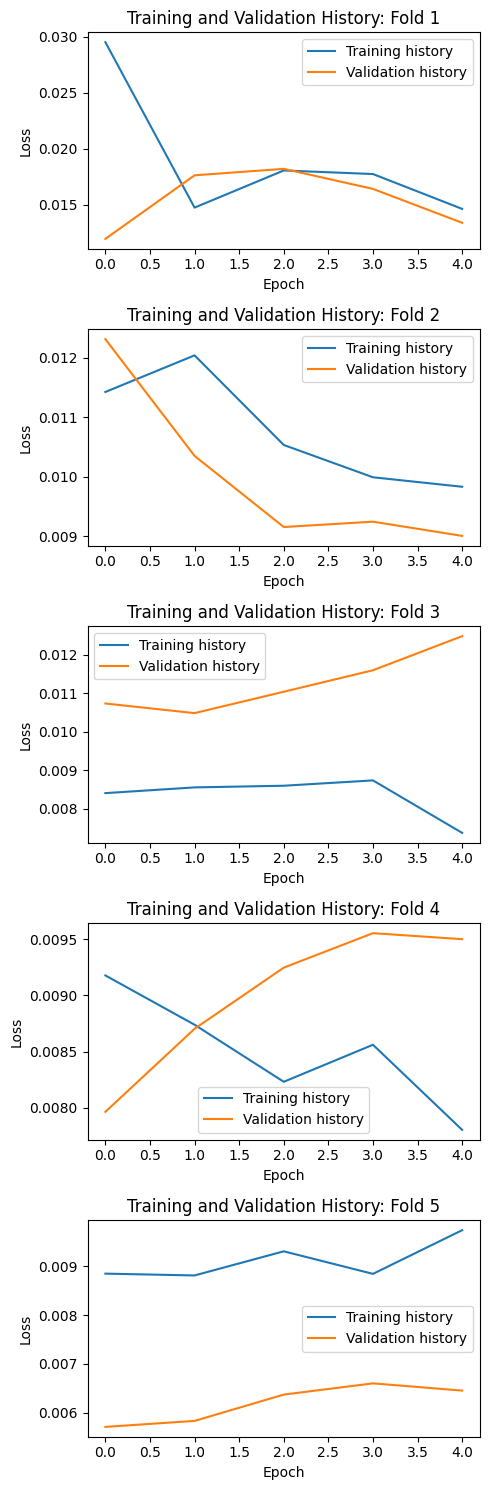

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,1, figsize=(5, 15))

for i in range(5):
    th = np.array(thist_array[i])
    vh = np.array(vhist_array[i])
    
    ax=axes[i]
    
    sns.lineplot(th, label='Training history', ax=ax)
    sns.lineplot(vh, label='Validation history', ax=ax)
    
    ax.set_title(f'Training and Validation History: Fold {i+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
  
plt.tight_layout()  
plt.show()

In [23]:
len(test_set)

19

In [24]:
sth = f'history/{dte}_thist.pt'
svh = f'history/{dte}_vhist.pt'
t.saved_thist = sth
t.saved_vhist = svh
torch.save(thist_array, sth)
torch.save(vhist_array, svh)

### Save the weights


In [25]:
s = f'RPN_test15a_weights_{dte}.pt'
s

'RPN_test15a_weights_Nov_16_2024_101308.pt'

In [26]:
model = config['model']

In [27]:
t.saved_weights = s
torch.save(model.state_dict(), s)

### Evaluation


In [28]:
test_dataloader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

In [29]:
h, mh = fitter.validation(test_dataloader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

In [30]:
valmets = pd.DataFrame(mh)
mets = valmets.mean()

In [31]:
t.iou = mets.iou_score
t.precision = mets.precision_score
t.recall = mets.recall_score
t.f1 = mets.f1_score

# Trial


In [32]:
model = fitter.model

In [33]:
sample = next(enumerate(test_dataloader))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

In [34]:
slices, masks, target, case = sample[1][1]

In [35]:
# x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [36]:
y = model(x, target)

In [37]:
y

tensor([[0.1634, 0.3174, 0.4685, 0.7130]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [38]:
fitter.loss(y, T[target])

tensor(108.0688, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [39]:
masks[target]

tensor([[[ 34.5703,  93.7500, 132.4219, 175.1953]]], dtype=torch.float64)

In [40]:
y

tensor([[0.1634, 0.3174, 0.4685, 0.7130]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [41]:
bbox = masks[target].squeeze().cpu().long()

In [42]:
y = (y*300).squeeze().detach().cpu().long()

In [43]:
bbox, y

(tensor([ 34,  93, 132, 175]), tensor([ 49,  95, 140, 213]))

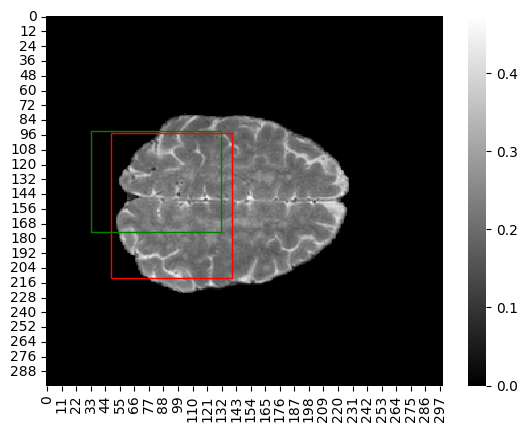

In [44]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(x[target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (y[0], y[1]),
    y[2] - y[0],
    y[3] - y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

# Log Progress


In [45]:
t.notes = '''
applied 5 kfold cross validation
'''

In [46]:
t()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-16 10:13:08.574707,RPN,None,None,False,True,True,False,True,<class 'torch.optim.adam.Adam'>,5,...,0.484041,0.406466,None,RPN_test15a_weights_Nov_16_2024_101308.pt,history/Nov_16_2024_101308_thist.pt,history/Nov_16_2024_101308_vhist.pt,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",Nov_16_2024_101308.log,cuda,\napplied 5 kfold cross validation\n


In [47]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, t()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    t().to_csv('history/runs.csv')

Merging to old df
